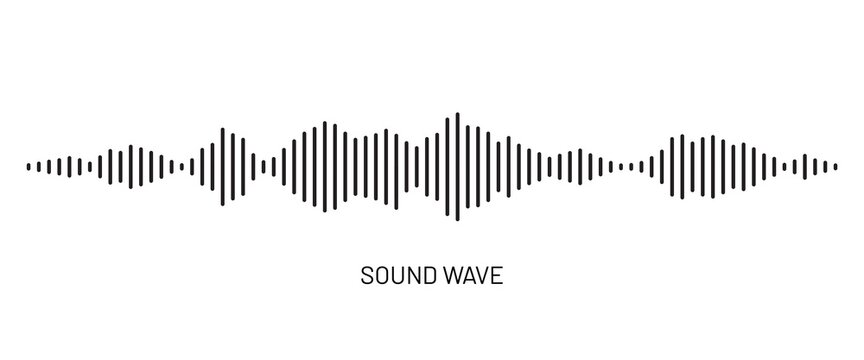

In [ ]:
# Import All Necessary Packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchaudio
import torch
import torch.nn as nn
from sklearn import model_selection
from sklearn import metrics
from tabulate import tabulate # tabulate print
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore") # Ignore All Warnings

# Read The csv file.
## Print First 5 row

In [ ]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df.head()

In [ ]:
wave = torchaudio.load("../input/urbansound8k/fold1/102106-3-0-0.wav")
plt.plot(wave[0].t().numpy())
print(wave[0].shape) # torch.Size([2, 72324]) 2 channels, 72324 sample_rate

# Process Audio Files That return specgram and label

In [ ]:
class AudioDataset:
    def __init__(self, file_path, class_id):
        self.file_path = file_path
        self.class_id = class_id
        
    def __len__(self):
        return len(self.file_path)
    
    def __getitem__(self, idx):
        path = self.file_path[idx]
        waveform, sr = torchaudio.load(path, normalization=True) # load audio
        audio_mono = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono
        tempData = torch.zeros([1, 160000])
        if audio_mono.numel() < 160000: # if sample_rate < 160000
            tempData[:, :audio_mono.numel()] = audio_mono
        else:
            tempData = audio_mono[:, :160000] # else sample_rate 160000
        audio_mono=tempData
        mel_specgram = torchaudio.transforms.MelSpectrogram(sr)(audio_mono) # (channel, n_mels, time)
        mel_specgram_norm = (mel_specgram - mel_specgram.mean()) / mel_specgram.std() # Noramalization
        mfcc = torchaudio.transforms.MFCC(sample_rate=sr)(audio_mono) # (channel, n_mfcc, time)
        mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std() # mfcc norm
        new_feat = torch.cat([mel_specgram, mfcc], axis=1)
        
        return {
            "specgram": torch.tensor(new_feat[0].permute(1, 0), dtype=torch.float),
            "label": torch.tensor(self.class_id[idx], dtype=torch.long)
        }

In [ ]:
# device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(data):
    specs = []
    labels = []
    for d in data:
        spec = d["specgram"].to(device)
        label = d["label"].to(device)
        specs.append(spec)
        labels.append(label)
    spec = torch.nn.utils.rnn.pad_sequence(specs, batch_first=True, padding_value=0.)
    labels = torch.tensor(labels)
    return spec, labels


FILE_PATH = "../input/urbansound8k/"

if __name__ == "__main__":
    df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
    files = df["slice_file_name"].values.tolist()
    folder_fold = df["fold"].values
    label = df["classID"].values.tolist()
    path = [
        os.path.join(FILE_PATH + "fold" + str(folder) + "/" + file) for folder, file in zip(folder_fold, files)
    ]
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(path, label, random_state=42, test_size=0.3)
    
    train_dataset = AudioDataset(
        file_path=X_train,
        class_id=y_train
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, drop_last=True, collate_fn=collate_fn
    )
    
    test_dataset = AudioDataset(
        file_path=X_test,
        class_id=y_test
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, shuffle=False, drop_last=True, collate_fn=collate_fn
    )

In [ ]:
# model
class AudioLSTM(nn.Module):

    def __init__(self, n_feature=5, out_feature=5, n_hidden=256, n_layers=2, drop_prob=0.3):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature
        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(int(n_hidden), int(n_hidden/2))
        self.fc2 = nn.Linear(int(n_hidden/2), out_feature)

    def forward(self, x, hidden):
        # x.shape (batch, seq_len, n_features)
        l_out, l_hidden = self.lstm(x, hidden)
        # out.shape (batch, seq_len, n_hidden*direction)
        out = self.dropout(l_out)
        # out.shape (batch, out_feature)
        out = self.fc1(out)
        out = self.fc2(out[:, -1, :])
#         print(out.shape)
        # return the final output and the hidden state
        return out, l_hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
#         print(hidden[0].shape)
        return hidden

In [ ]:
AudioLSTM()

In [ ]:
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Save Model

In [ ]:
def save_model(state, filename):
    torch.save(state, filename)
    print("-> Model Saved")

In [ ]:
# Train Set
def train(data_loader, model, epoch, optimizer, device):
    losses = []
    accuracies = []
    labels = []
    preds = []
    model.train()
    loop = tqdm(data_loader) # for progress bar
    for batch_idx, (data, target) in enumerate(loop):
        data = data.to(device)
        target = target.to(device)
        model.zero_grad()
        output, hidden_state = model(data, model.init_hidden(128))
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        probs = torch.softmax(output, dim=1)
        winners = probs.argmax(dim=1)
        corrects = (winners == target)
        accuracy = corrects.sum().float() / float(target.size(0))
        accuracies.append(accuracy)
        labels += torch.flatten(target).cpu()
        preds += torch.flatten(winners).cpu()
        loop.set_description(f"EPOCH: {epoch} | ITERATION : {batch_idx}/{len(data_loader)} | LOSS: {loss.item()} | ACCURACY: {accuracy}")
        loop.set_postfix(loss=loss.item())
        
    avg_train_loss = sum(losses) / len(losses)
    avg_train_accuracy = sum(accuracies) / len(accuracies)
    report = metrics.classification_report(torch.tensor(labels).numpy(), torch.tensor(preds).numpy())
    print(report)
    return avg_train_loss, avg_train_accuracy

In [ ]:
# Test Setting
def test(data_loader, model, optimizer, device):
    model.eval()
    accs = []
    preds = []
    labels = []
    test_accuracies = []
    with torch.no_grad():
        loop = tqdm(data_loader) # Test progress bar
        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(device)
            target = target.to(device)
            output, hidden_state = model(data, model.init_hidden(128))
            probs = torch.softmax(output, dim=1)
            winners = probs.argmax(dim=1)
            corrects = (winners == target)
            accuracy = corrects.sum().float() / float(target.size(0))
            
            test_accuracies.append(accuracy)
            labels += torch.flatten(target).cpu()
            preds += torch.flatten(winners).cpu()
    avg_test_acc = sum(test_accuracies) / len(test_accuracies)
    return avg_test_acc

In [ ]:
# Epoch
EPOCH = 50
OUT_FEATURE = 10 # class
PATIENCE = 5

# What is AdamW
> Optimizer that implements the Adam algorithm with weight decay.

# Is AdamW better than Adam?

> The authors show experimentally that AdamW yields better training loss and that the models generalize much better than models trained with Adam allowing the new version to compete with stochastic gradient descent with momentum.


In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AudioLSTM(n_feature=168, out_feature=OUT_FEATURE).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=PATIENCE)
    
    best_train_acc, best_epoch = 0, 0 # update acc and epoch
    
    for epoch in range(EPOCH):
        avg_train_loss, avg_train_acc = train(train_loader, model, epoch, optimizer, device)
        avg_test_acc = test(test_loader, model, optimizer, device)
        scheduler.step(avg_train_acc)
        if avg_train_acc > best_train_acc:
            best_train_acc = avg_train_acc
            best_epoch = epoch
            filename = f"best_model_at_epoch_{best_epoch}.pth.tar"
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            save_model(checkpoint, filename)
        
        table = [
            ["avg_train_loss", avg_train_loss], ["avg_train_accuracy", avg_train_acc],
            ["best_train_acc", best_train_acc], ["best_epoch", best_epoch]
        ]
        print(tabulate(table)) # tabulate View
        test_table = [
            ["Avg test accuracy", avg_test_acc]
        ]
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Accuracy/train', avg_train_acc, epoch)
        writer.add_scalar('Accuracy/test', avg_test_acc, epoch)
        print(tabulate(test_table)) # tabulate View

if __name__ == "__main__":
    main() # Run function

In [ ]:
bbjhjasdhjahsdjhasvvbvbhjhjhjhjhjhjghghghghfsdf

In [ ]:
unique_label = dict(zip(df["classID"], df["class"]))
print(unique_label)

# for single output test

In [ ]:
waveform, sr = torchaudio.load("../input/urbansound8k/fold2/100652-3-0-3.wav")
audio_mono = torch.mean(waveform, dim=0, keepdim=True)
tempData = torch.zeros([1, 160000])
if audio_mono.numel() < 160000:
    tempData[:, :audio_mono.numel()] = audio_mono
else:
    tempData = audio_mono[:, :160000]
audio_mono=tempData
mel_specgram = torchaudio.transforms.MelSpectrogram(sr)(audio_mono)
mel_specgram_norm = (mel_specgram - mel_specgram.mean()) / mel_specgram.std()
mfcc = torchaudio.transforms.MFCC(sample_rate=sr)(audio_mono)
#         print(f'mfcc {mfcc.size()}')
mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()
new_feat = torch.cat([mel_specgram, mfcc], axis=1)

data = torch.utils.data.DataLoader(new_feat.permute(0, 2, 1))
new = torch.load("./best_model_at_epoch_49.pth.tar", map_location=torch.device("cpu"))["state_dict"]
model = AudioLSTM(n_feature=168, out_feature=OUT_FEATURE)
model.load_state_dict(new)
model.eval().cpu()
with torch.no_grad():
    for x in data:
        x = x.to("cpu")
        output, hidden_state = model(x, (torch.zeros(2, 1, 256), torch.zeros(2, 1, 256)))
        for i, v in unique_label.items():
            if np.argmax(output.numpy()) == i:
                print(f"Predicted Label : {v}")

# for a fold test

In [ ]:
PATH = "../input/urbansound8k/fold2"
    
fold2 = os.listdir("../input/urbansound8k/fold2")[:100]
for i in range(len(fold2)):
    class_name = df[df["slice_file_name"]==fold2[i]]['class']
    for item, value in class_name.items():
        print(f"Actual output : {value}")
    waveform, sr = torchaudio.load(os.path.join(PATH, fold2[i]))
    audio_mono = torch.mean(waveform, dim=0, keepdim=True)
    tempData = torch.zeros([1, 160000])
    if audio_mono.numel() < 160000:
        tempData[:, :audio_mono.numel()] = audio_mono
    else:
        tempData = audio_mono[:, :160000]
    audio_mono=tempData
    mel_specgram = torchaudio.transforms.MelSpectrogram(sr)(audio_mono)
    mel_specgram_norm = (mel_specgram - mel_specgram.mean()) / mel_specgram.std()
    mfcc = torchaudio.transforms.MFCC(sample_rate=sr)(audio_mono)
    #         print(f'mfcc {mfcc.size()}')
    mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()
    new_feat = torch.cat([mel_specgram, mfcc], axis=1)

    data = torch.utils.data.DataLoader(new_feat.permute(0, 2, 1))
    new = torch.load("./best_model_at_epoch_49.pth.tar", map_location=torch.device("cpu"))["state_dict"]
    model = AudioLSTM(n_feature=168, out_feature=OUT_FEATURE)
    model.load_state_dict(new)
    model.eval().cpu()
    with torch.no_grad():
        for x in data:
            x = x.to("cpu")
            output, hidden_state = model(x, (torch.zeros(2, 1, 256), torch.zeros(2, 1, 256)))
            for i, v in unique_label.items():
                if np.argmax(output.numpy()) == i:
                    print(f"Predicted Label : {v}")